## Interpolation
This notebook demonstrates how SEPAL uses interpolation.
Briefly, if a patient-specific AIF is generated from a series concentration-time points, the AIF object can return a concentration value at *arbitrary* times using interpolation.
This has two main use cases:
- To calculate tissue concentration at higher precision using a pharmacokinetic model (setting upsample_factor>1). Of course, interpolating the AIF doesn't recover any missing information, but it may increase the precision of the convolution operation used to calculate tissue concentration, since the impulse response function is continuous and will be digitised more finely.This use case is demonstrated in the notebook *demo_pk_models*.
- When data are sampled unevenly in time, or if some data points are missing/rejected. By default, the PK model object samples the AIF and IRF according to the minimum time spacing between data points. Interpolation is used to estimate the AIF at the missing times. In this situation, it is essential to set upsample_factor>>1 in the pharmacokinetic model object to obtain optimal accuracy. This use case is demonstrated below.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sepal import dce_fit, aifs, pk_models
%load_ext autoreload
%autoreload 2

### Create some AIF data

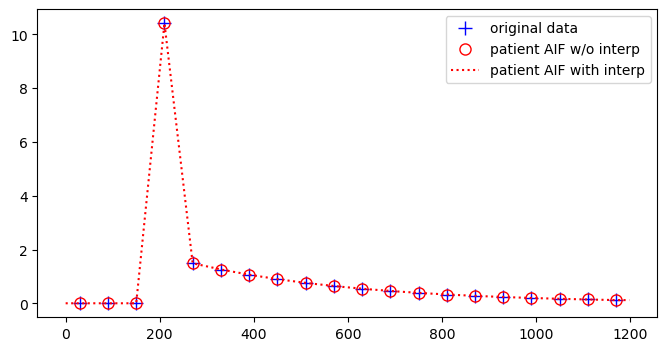

In [2]:
# define  timepoints
dt = 60
t = np.arange(0,20)*dt + dt/2

# generate AIF data at these time points using the Parker function
c_ap = aifs.Parker(hct=0.42, t_start=200).c_ap(t)
plt.figure(figsize=(8,4))
plt.plot(t, c_ap, 'b+', markersize=10, label='original data')

# Assuming this is the measured AIF, create a patient-specific AIF object based on these data points
aif_patient = aifs.PatientSpecific(t, c_ap)
c_ap_patient = aif_patient.c_ap(t)
plt.plot(t, aif_patient.c_ap(t), 'ro', markerfacecolor='none', markersize=8, label='patient AIF w/o interp')

# now create a finely-spaced set of time points and get (interpolated) AIF at these times
t_fine = np.arange(0, 1199)
plt.plot(t_fine, aif_patient.c_ap(t_fine), 'r:', label='patient AIF with interp')

plt.legend();

### Now remove some points from the measured data before creating the AIF object
Interpolation is used to "recover" the missing data.

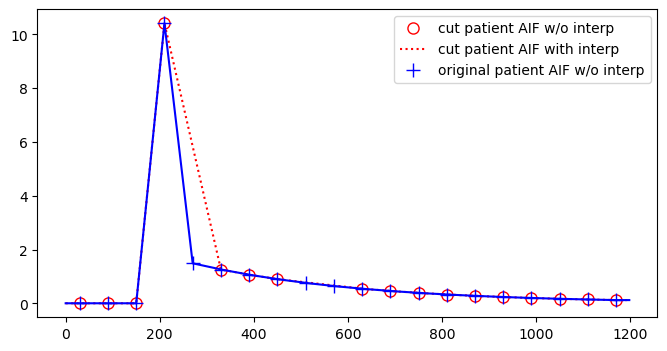

In [3]:
# cut out some of the original data points and create new patient-specific AIF
idxs_to_delete = np.array([4, 8, 9])
t_cut, c_ap_cut = np.delete(t, idxs_to_delete), np.delete(c_ap, idxs_to_delete)
# t_cut, c_ap_cut = t, c_ap
aif_patient_cut = aifs.PatientSpecific(t_cut, c_ap_cut)

plt.figure(figsize=(8,4))
# plot c_ap using the new and old AIF objects
plt.plot(t_cut, aif_patient_cut.c_ap(t_cut), 'ro', markerfacecolor='none', markersize=8, label='cut patient AIF w/o interp')
plt.plot(t_fine, aif_patient_cut.c_ap(t_fine), 'r:', label='cut patient AIF with interp')
plt.plot(t, aif_patient.c_ap(t), 'b+', markersize=10, label='original patient AIF w/o interp')
plt.plot(t_fine, aif_patient.c_ap(t_fine), 'b-')
plt.legend();

### The impact on model fitting
What effect does missing data and interpolation have on model fitting results

parameter: value / ground truth / % error
vp: 0.010151 / 0.010000 / 1.51
ps: 0.000945 / 0.001000 / -5.50


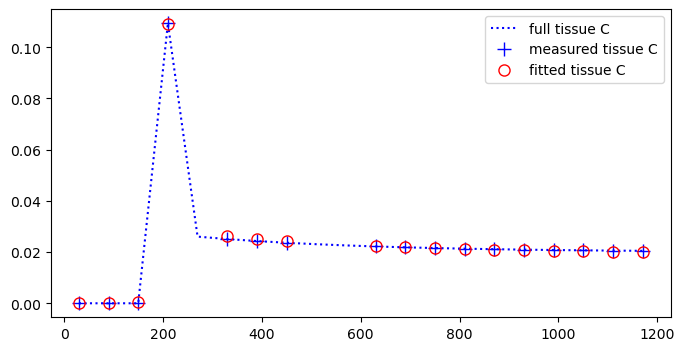

In [4]:
# generate "measured" concentration using the full patient-specific AIF
pk_model_ground_truth = pk_models.Patlak(t, aif_patient, upsample_factor=50)
pk_pars_ground_truth = {'vp': 0.01, 'ps': 1e-3} 
C_t, _c_cp, _c_e = pk_model_ground_truth.conc(**pk_pars_ground_truth)

# remove some data points from the C_t curve 
C_t_cut = np.delete(C_t, idxs_to_delete)
# C_t_cut = C_t

plt.figure(figsize=(8, 4))
plt.plot(t, C_t, 'b:', label='full tissue C')
plt.plot(t_cut, C_t_cut, 'b+', markersize=10, label='measured tissue C')

# now fit reduced data points using cut-down AIF
pk_model = pk_models.Patlak(t_cut, aif_patient_cut, upsample_factor=50)
vp_fit, ps_fit, C_t_fit = dce_fit.ConcToPKP(pk_model).proc(C_t_cut)

plt.plot(t_cut, C_t_fit, 'ro', markerfacecolor='none', markersize=8, label='fitted tissue C')
plt.legend()
 
print("parameter: value / ground truth / % error")
print(f"vp: {vp_fit:.6f} / {pk_pars_ground_truth['vp']:.6f} / {100*(vp_fit-pk_pars_ground_truth['vp'])/pk_pars_ground_truth['vp']:.2f}")
print(f"ps: {ps_fit:.6f} / {pk_pars_ground_truth['ps']:.6f} / {100*(ps_fit-pk_pars_ground_truth['ps'])/pk_pars_ground_truth['ps']:.2f}")